In [87]:
# Import statements
import numpy as numpy
import pandas as pd
import seaborn as sns #for plotting
import matplotlib.pyplot as plt
import random

In [88]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

In [89]:
# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]

In [90]:
combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

In [91]:
shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

In [92]:
l = ['CTLA-4', 'TIM3', 'PD-1', 'PD-L1', 'KIR', 'LAG3']

new_df = pd.DataFrame(index = l)

for item in l:
    count = shuffled_df[shuffled_df['compound'].str.contains(item, na=False)].shape[0]
    new_df.loc[item, 'count'] = count

new_df = new_df.reset_index()
new_df.columns = ['checkpoint', 'count'] 

In [93]:
# 1. Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# 2. Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# 3. Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# # 4. Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# # 5. Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint', 'pdb', 'Hchain', 'Lchain', 'antigen_chain']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2002865464.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2002865464.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


,antibody,checkpoint,pdb,Hchain,Lchain,antigen_chain
1,CEMIPLIMAB,PD-1,7wvm,A,B,E
2,CEMIPLIMAB,PD-1,8gy5,A,B,Q
3,PEMBROLIZUMAB,PD-1,5jxe,G,F,A
4,NIVOLUMAB,PD-1,5wt9,H,L,G
5,IPILIMUMAB,CTLA-4,7su1,H,L,C
6,ATEZOLIZUMAB,PD-L1,5x8l,S,N,D
7,CEMIPLIMAB,PD-1,8gy5,H,L,P
9,IPILIMUMAB,CTLA-4,7su0,H,L,C
10,NaN,NaN,6k0y,A,B,C
11,PEMBROLIZUMAB,PD-1,5jxe,D,C,B


In [94]:
pdb_list = shuffled_df_ab['pdb'].unique().tolist()
#shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

with open('pdb_list.txt', 'w') as f:
    for pdb in pdb_list:
        f.write(pdb + '\n')

In [95]:
# make a list of the columns 
shuffled_df_ab = shuffled_df_ab[['pdb', 'Hchain', 'Lchain', 'antigen_chain']]
extracted_list = shuffled_df_ab.values.tolist()

extracted_list


[['7wvm', 'A', 'B', 'E'],
 ['8gy5', 'A', 'B', 'Q'],
 ['5jxe', 'G', 'F', 'A'],
 ['5wt9', 'H', 'L', 'G'],
 ['7su1', 'H', 'L', 'C'],
 ['5x8l', 'S', 'N', 'D'],
 ['8gy5', 'H', 'L', 'P'],
 ['7su0', 'H', 'L', 'C'],
 ['6k0y', 'A', 'B', 'C'],
 ['5jxe', 'D', 'C', 'B'],
 ['5ggs', 'A', 'B', 'Z'],
 ['5b8c', 'H', 'G', 'I'],
 ['6txz', 'K', 'O', 'D'],
 ['5ggr', 'A', 'B', 'Y'],
 ['7wsl', 'H', 'L', 'D'],
 ['5ggv', 'H', 'L', 'Y'],
 ['5b8c', 'B', 'A', 'C'],
 ['6txz', 'H', 'L', 'A'],
 ['5xj3', 'G', 'H', 'I'],
 ['7wvm', 'C', 'D', 'F'],
 ['5xxy', 'H', 'L', 'A'],
 ['7cgw', 'H', 'L', 'P'],
 ['5x8l', 'H', 'M', 'C'],
 ['6txz', 'I', 'M', 'B'],
 ['6rp8', 'h', 'l', 'c'],
 ['6txz', 'J', 'N', 'C'],
 ['5xj3', 'J', 'K', 'L'],
 ['5xj4', 'H', 'L', 'A'],
 ['5ggr', 'H', 'L', 'Z'],
 ['5b8c', 'K', 'J', 'L'],
 ['6rp8', 'H', 'L', 'C'],
 ['5x8l', 'J', 'O', 'E'],
 ['5tru', 'h', 'l', 'c'],
 ['7bxa', 'B', 'C', 'A'],
 ['5xj3', 'A', 'B', 'C'],
 ['5tru', 'H', 'L', 'C'],
 ['5x8m', 'B', 'C', 'A'],
 ['5b8c', 'E', 'D', 'F'],
 ['8tui', 'H

# Paratope, Hydrogen-Bonds, Saltbridges

In [96]:
import os
from pymol import cmd
import pandas as pd

results = []

# input 
root_folder = "structures"
cutoff_distance = 5.0  # in Å distance
hbond_cutoff = 3.5  # in Å distance for hydrogen bonds
salt_cutoff = 4.0  # in Å distance for salt bridges

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data if available

# Your extracted list from your DataFrame Format: [pdb_id, H_chain, L_chain, antigen_chain]

# Loop over each chain combination from the extracted list
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

        cmd.reinitialize()
        cmd.load(pdb_path)

        # Selections
        cmd.select("antibody", f"chain {h_chain}+{l_chain}")
        cmd.select("antigen", f"chain {ag_chain}")
        cmd.select("paratope", f"antibody within {cutoff_distance} of antigen")

        # Color antibody chains 
        cmd.color("marine", f"chain {h_chain}")
        cmd.color("skyblue", f"chain {l_chain}")

        # Color antigen chain (e.g., salmon)
        cmd.color("salmon", "antigen")

        # Optional: highlight paratope (already near antigen)
        cmd.color("yellow", "paratope")

        # Surface area
        paratope_area = cmd.get_area("paratope")
        print(f"   ➤ Epitope surface area: {paratope_area:.2f} Å²")

        # Hydrogen bonds
        hbonds = cmd.find_pairs("antibody", "antigen", mode=1, cutoff=hbond_cutoff)
        num_hbonds = len(hbonds)
        print(f"Found {num_hbonds} hydrogen bonds at the interface.")

        # salt bridges 
        # 1) antibody acidic O  → antigen basic N
        cmd.select("acidic_ab", f"chain {h_chain}+{l_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ag",  f"chain {ag_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb1 = cmd.find_pairs("acidic_ab", "basic_ag", cutoff=salt_cutoff, mode=1)

        # 2) antigen acidic O → antibody basic N
        cmd.select("acidic_ag", f"chain {ag_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ab",  f"chain {h_chain}+{l_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb2 = cmd.find_pairs("acidic_ag", "basic_ab", cutoff=salt_cutoff, mode=1)

        # cleanup salt-bridge selections
        for sel in ("acidic_ab","basic_ag","acidic_ag","basic_ab"):
            cmd.delete(sel)

        num_salt_bridges = len(sb1) + len(sb2)
        print(f"   ➤ Salt bridges: {num_salt_bridges}")

        # save session (optional) 
        session_out = os.path.join(dirpath, f"{pdb_id}paratope.pse")
        cmd.save(session_out)

        # collect results 
        results.append({
            "pdb_id":              pdb_id,
            "H_chain":             h_chain,
            "L_chain":             l_chain,
            "antigen_chain":       ag_chain,
            "paratope_area":       paratope_area,
            "num_hydrogen_bonds":  num_hbonds,
            "num_salt_bridges":    num_salt_bridges,
            "folder":              os.path.basename(dirpath)
        })

# Save to CSV
df = pd.DataFrame(results)
# Remove duplicate block
# Save results to CSV 
df = pd.DataFrame(results)
df.to_csv("paratope_surface_hbonds_summary.csv", index=False)

print("All done. Results saved to 'paratope_surface_hbonds_summary.csv'")

Processing 7wvm...
   ➤ Epitope surface area: 1319.53 Å²
Found 16 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 8gy5...
   ➤ Epitope surface area: 1424.74 Å²
Found 16 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5jxe...
   ➤ Epitope surface area: 1549.54 Å²
Found 19 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5wt9...
   ➤ Epitope surface area: 1760.50 Å²
Found 33 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 7su1...
   ➤ Epitope surface area: 1082.11 Å²
Found 14 hydrogen bonds at the interface.
   ➤ Salt bridges: 2
Processing 5x8l...
   ➤ Epitope surface area: 1629.12 Å²
Found 24 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 8gy5...
   ➤ Epitope surface area: 1495.28 Å²
Found 19 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 7su0...
   ➤ Epitope surface area: 1257.50 Å²
Found 15 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 6k0y...
   ➤ Epitope surface 

In [97]:
import pandas as pd

df = pd.read_csv("paratope_surface_hbonds_summary.csv")
print(df['pdb_id'].value_counts())

pdb_id
5x8l    5
5xj3    4
5b8c    4
6txz    4
5ggr    2
7cu5    2
7bxa    2
5tru    2
6rp8    2
7cgw    2
8gy5    2
7wvm    2
5ggs    2
7su0    2
5jxe    2
7wsl    1
5ggv    1
5xxy    1
6k0y    1
5xj4    1
7su1    1
5wt9    1
5x8m    1
8tui    1
5grj    1
9dq3    1
9dq4    1
6xkr    1
Name: count, dtype: int64


## Plotting the results 

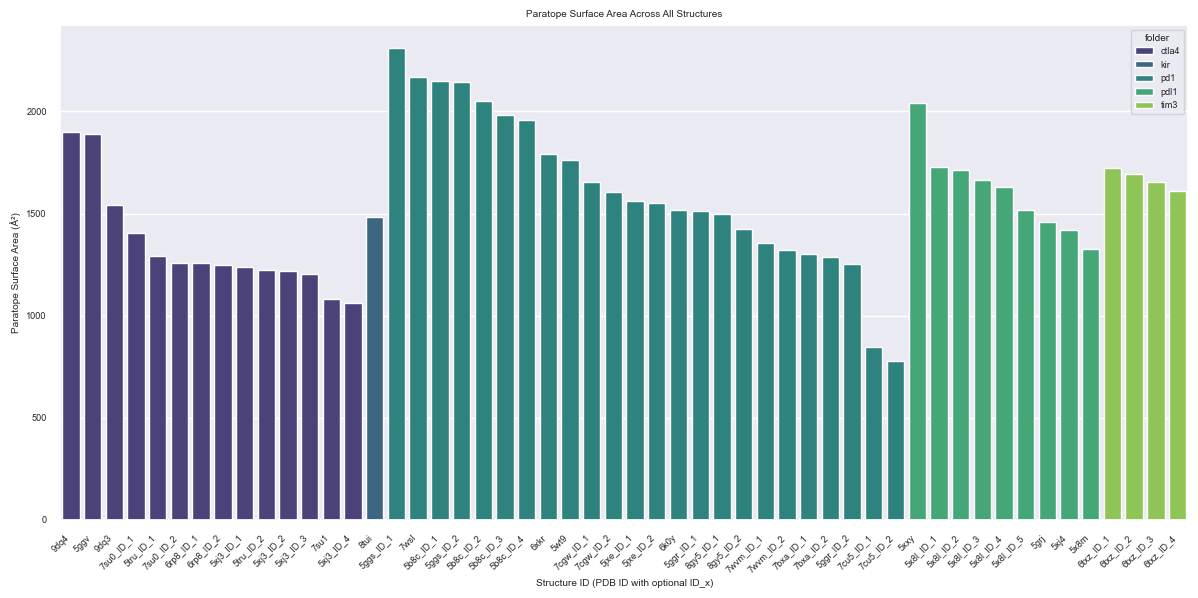

In [98]:
from collections import defaultdict, Counter 

# Sort as before
df_sorted = df.sort_values(by=["folder", "paratope_area"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="paratope_area", hue="folder", dodge=False, palette="viridis")

plt.title("Paratope Surface Area Across All Structures")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Paratope Surface Area (Å²)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/paratopee_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()



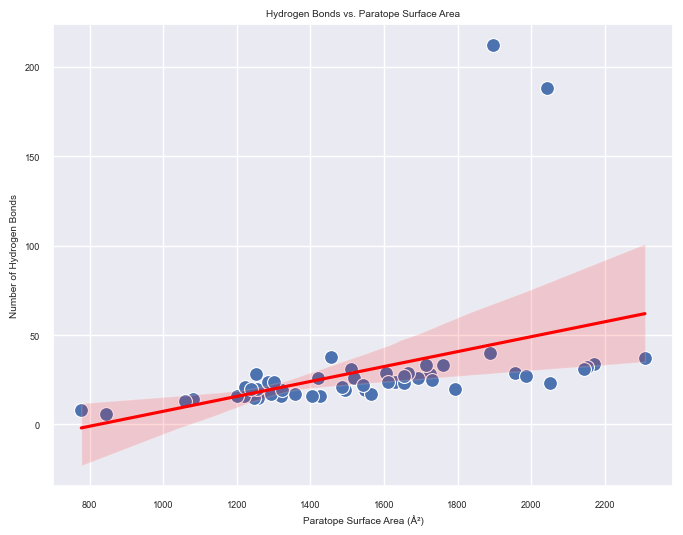

In [99]:
df = pd.read_csv("paratope_surface_hbonds_summary.csv")

# Scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="paratope_area", y="num_hydrogen_bonds", s=100)
sns.regplot(data=df, x="paratope_area", y="num_hydrogen_bonds", scatter=False, color="red")
plt.xlabel("Paratope Surface Area (Å²)")
plt.ylabel("Number of Hydrogen Bonds")
plt.title("Hydrogen Bonds vs. Paratope Surface Area")
plt.grid(True)
plt.show()

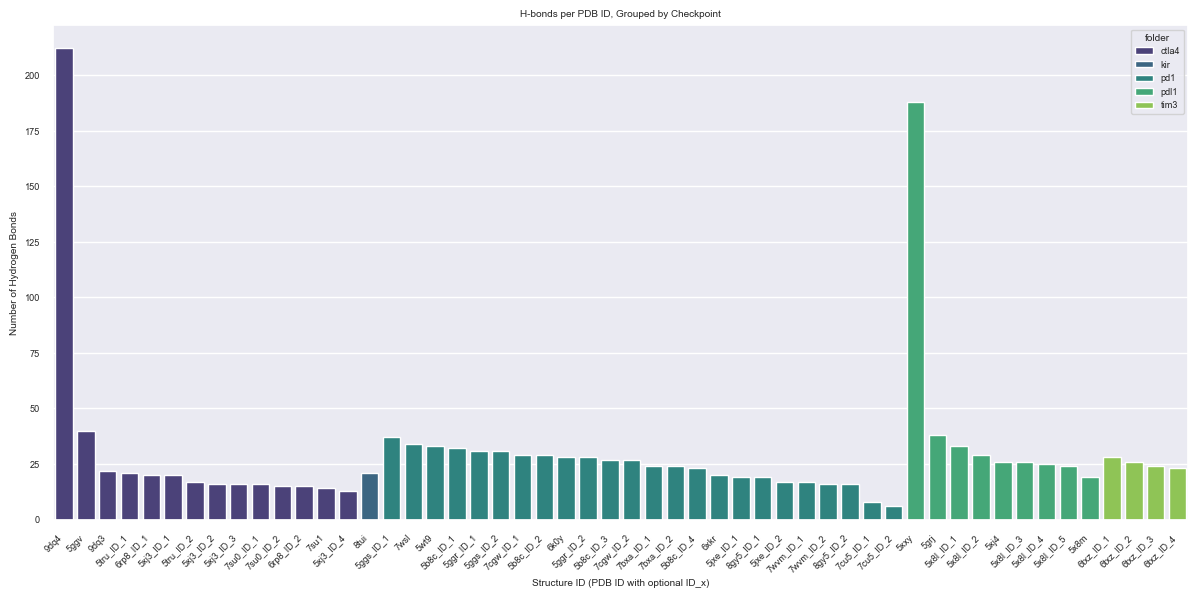

In [100]:
from collections import defaultdict, Counter 

# Sort as before
df_sorted = df.sort_values(by=["folder", "num_hydrogen_bonds"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="num_hydrogen_bonds", hue="folder", dodge=False, palette="viridis")

plt.title("H-bonds per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Hydrogen Bonds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/h_bonds_per_PDB.pdf', bbox_inches='tight')
plt.show()

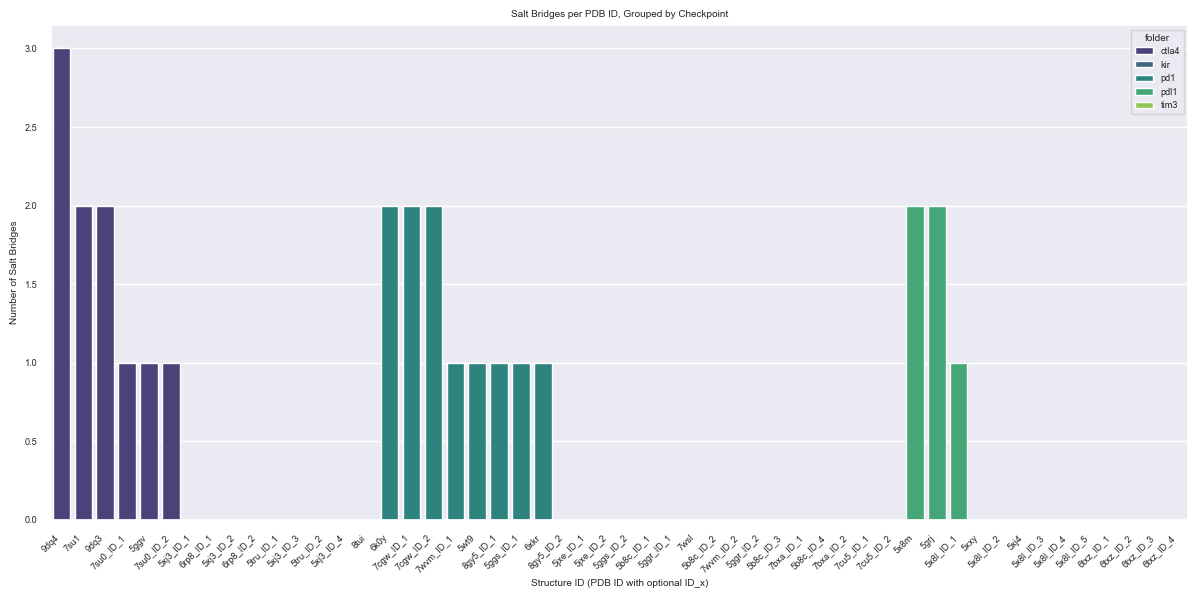

In [101]:
from collections import defaultdict, Counter

# Sort as before
df_sorted = df.sort_values(by=["folder", "num_salt_bridges"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids


# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="num_salt_bridges", hue="folder", dodge=False, palette="viridis")

plt.title("Salt Bridges per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Salt Bridges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('plots/salt_bridges_per_PDB.pdf', bbox_inches='tight')
plt.show() 

# Binding Score 

In [102]:
from sklearn.preprocessing import MinMaxScaler

#normalizing
scaler = MinMaxScaler()
df = pd.read_csv("paratope_surface_hbonds_summary.csv")
features = df[["num_hydrogen_bonds", "num_salt_bridges", "paratope_area"]]
normalized = scaler.fit_transform(features)

df_norm = pd.DataFrame(normalized, columns=features.columns)
df_norm["pdb_id"] = df["pdb_id"]  

# Create a binding strength score
weights = {
    "num_hydrogen_bonds": 0.4,
    "num_salt_bridges": 0.4,
    "paratope_area": 0.2
}

df_norm["binding_score"] = (
    df_norm["num_hydrogen_bonds"] * weights["num_hydrogen_bonds"] +
    df_norm["num_salt_bridges"] * weights["num_salt_bridges"] +
    df_norm["paratope_area"] * weights["paratope_area"]
)

# Show top binders
print(df_norm.sort_values("binding_score", ascending=False)[["pdb_id", "binding_score"]])


   pdb_id  binding_score
48   9dq4       0.946239
20   5xxy       0.518688
49   7cgw       0.421995
21   7cgw       0.419402
41   5grj       0.417499
8    6k0y       0.405964
45   9dq3       0.397650
36   5x8m       0.363269
47   5ggs       0.360336
15   5ggv       0.344438
4    7su1       0.321967
3    5wt9       0.314146
51   6xkr       0.292989
5    5x8l       0.279508
10   5ggs       0.260194
6    8gy5       0.252315
14   7wsl       0.236411
42   7su0       0.234503
16   5b8c       0.229987
0    7wvm       0.223532
7    7su0       0.213487
11   5b8c       0.199163
29   5b8c       0.198566
37   5b8c       0.198451
22   5x8l       0.174748
12   6txz       0.166478
50   5x8l       0.161242
31   5x8l       0.160616
17   6txz       0.158448
25   6txz       0.147660
28   5ggr       0.144378
23   6txz       0.143712
44   5x8l       0.135432
2    5jxe       0.126071
9    5jxe       0.124032
27   5xj4       0.122888
38   8tui       0.121516
13   5ggr       0.104701
1    8gy5       0.103942


In [103]:
from collections import Counter, defaultdict

# Sort the dataframe
df_sorted = df_norm.sort_values(
    by=["binding_score", "num_hydrogen_bonds", "num_salt_bridges", "paratope_area"],
    ascending=[False, False, False, False]  # show top-scoring binders first
).copy()
# Count appearances
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build unique structure IDs
structure_ids = []
for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

# Add to DataFrame
df_sorted["structure_id"] = structure_ids

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/3630168040.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")


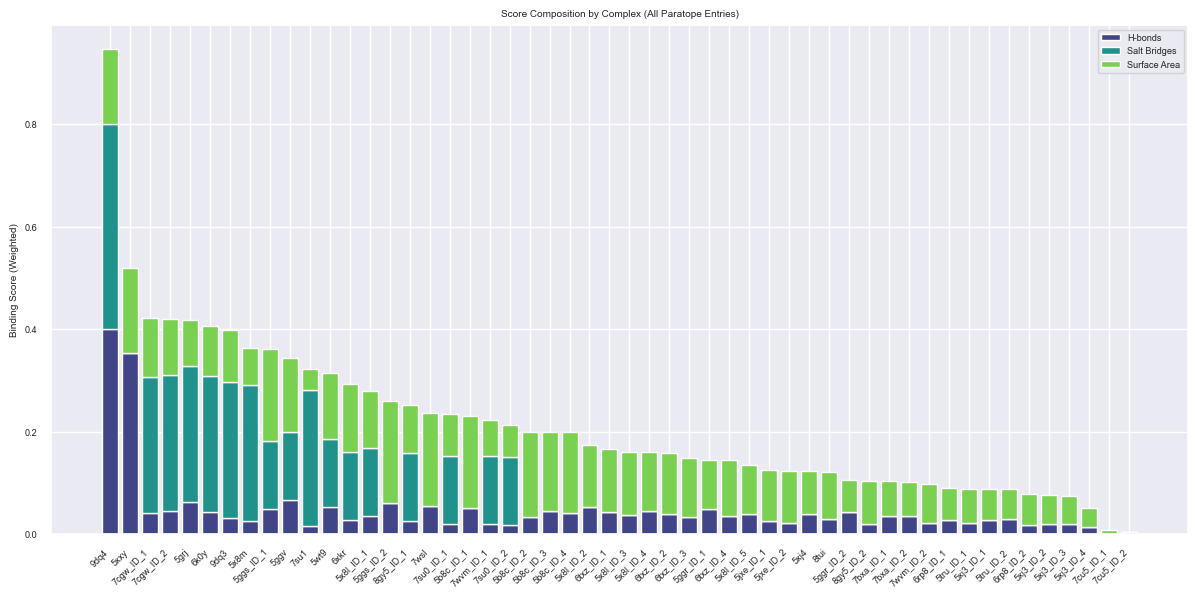

In [104]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Sort by binding score again
top = df_sorted.sort_values("binding_score", ascending=False)

# Use viridis colormap
viridis = cm.get_cmap("viridis")
colors = viridis(np.linspace(0.2, 0.8, 3))

plt.figure(figsize=(12, 6))

# Plot H-bonds
plt.bar(
    top["structure_id"],
    top["num_hydrogen_bonds"] * 0.4,
    label="H-bonds",
    color=colors[0],
    bottom=0
)

# Plot Salt Bridges
plt.bar(
    top["structure_id"],
    top["num_salt_bridges"] * 0.4,
    label="Salt Bridges",
    color=colors[1],
    bottom=top["num_hydrogen_bonds"] * 0.4
)

# Plot Surface Area
plt.bar(
    top["structure_id"],
    top["paratope_area"] * 0.2,
    label="Surface Area",
    color=colors[2],
    bottom=(top["num_hydrogen_bonds"] + top["num_salt_bridges"]) * 0.4
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Binding Score (Weighted)")
plt.title("Score Composition by Complex (All Paratope Entries)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/paratope_binding_affinity_score.pdf", bbox_inches="tight")
plt.show()


# Sequences Paratope

In [105]:
# not unqiue sequences 
import os
from pymol import cmd
from Bio.SeqUtils import seq1
import pandas as pd
from collections import defaultdict, Counter

# Input settings
root_folder = "structures"
cutoff_distance = 5.0  # in Å
results = []

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data

# Loop through all extracted entries
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

    cmd.reinitialize()
    cmd.load(pdb_path)

    # Define selections
    cmd.select("antibody", f"chain {h_chain}+{l_chain}")
    cmd.select("antigen", f"chain {ag_chain}")
    cmd.select("paratope", f"antibody within {cutoff_distance} of antigen")

    # Extract unique residues from epitope
    model = cmd.get_model("paratope")
    seen = set()
    residues = []
    for atom in model.atom:
        res_id = (atom.chain, atom.resi)
        if res_id not in seen:
            seen.add(res_id)
            residues.append(atom.resn)

    sequence = ''.join(seq1(res) for res in residues if res != "HOH")

    # Collect results
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        "paratope_sequence": sequence,
        "folder": os.path.basename(dirpath)
    })

# Convert to DataFrame
df_seq = pd.DataFrame(results)

# Assign unique structure_id like in other analyses
df_seq = df_seq.sort_values(by=["folder", "paratope_sequence"], ascending=[True, False]).copy()
id_frequencies = Counter(df_seq["pdb_id"])
id_tracker = defaultdict(int)

structure_ids = []
for pdb_id in df_seq["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_seq["structure_id"] = structure_ids

# Save CSV
df_seq.to_csv("paratope_sequences_summary.csv", index=False)
print("Summary table saved to 'paratope_sequences_summary.csv'")

# Save FASTA
with open("paratope_sequences.fasta", "w") as f:
    for _, row in df_seq.iterrows():
        f.write(f">{row['structure_id']}\n{row['paratope_sequence']}\n")

print("FASTA file saved to 'paratope_sequences.fasta'")

# Add sequence to df_sorted

df_sorted = df_seq.sort_values(by=["folder", "paratope_sequence"], ascending=[True, False]).copy()
   


Processing 7wvm...
Processing 8gy5...
Processing 5jxe...
Processing 5wt9...
Processing 7su1...
Processing 5x8l...
Processing 8gy5...
Processing 7su0...
Processing 6k0y...
Processing 5jxe...
Processing 5ggs...
Processing 5b8c...
Processing 6txz...
Processing 5ggr...
Processing 7wsl...
Processing 5ggv...
Processing 5b8c...
Processing 6txz...
Processing 5xj3...
Processing 7wvm...
Processing 5xxy...
Processing 7cgw...
Processing 5x8l...
Processing 6txz...
Processing 6rp8...
Processing 6txz...
Processing 5xj3...
Processing 5xj4...
Processing 5ggr...
Processing 5b8c...
Processing 6rp8...
Processing 5x8l...
Processing 5tru...
Processing 7bxa...
Processing 5xj3...
Processing 5tru...
Processing 5x8m...
Processing 5b8c...
Processing 8tui...
Processing 7bxa...
Processing 7cu5...
Processing 5grj...
Processing 7su0...
Processing 7cu5...
Processing 5x8l...
Processing 9dq3...
Processing 5xj3...
Processing 5ggs...
Processing 9dq4...
Processing 7cgw...
Processing 5x8l...
Processing 6xkr...
Summary tabl

In [106]:
print(df_sorted)

   pdb_id H_chain L_chain antigen_chain  \
15   5ggv       H       L             Y   
24   6rp8       h       l             c   
30   6rp8       H       L             C   
32   5tru       h       l             c   
34   5xj3       A       B             C   
26   5xj3       J       K             L   
18   5xj3       G       H             I   
46   5xj3       D       E             F   
35   5tru       H       L             C   
45   9dq3       H       L             C   
48   9dq4       H       L             A   
7    7su0       H       L             C   
42   7su0       I       M             D   
4    7su1       H       L             C   
38   8tui       H       L             A   
21   7cgw       H       L             P   
14   7wsl       H       L             D   
47   5ggs       C       D             Y   
10   5ggs       A       B             Z   
2    5jxe       G       F             A   
29   5b8c       K       J             L   
11   5b8c       H       G             I   
9    5jxe  

## Identiy Matrix

In [179]:
from Bio import SeqIO # to read sequences from a FASTA file
from Bio import pairwise2 # pairwise sequence alignments
import pandas as pd

# Load your sequences
records = list(SeqIO.parse("paratope_sequences.fasta", "fasta"))

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq) # Align two sequences (whole sequence)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100  # identiy in % -> (number of matches) / (length of longer sequence) × 100
        row.append(round(identity, 2))
    matrix.append(row)

# Create a DataFrame
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save & show
df_identity.to_csv("paratope_sequence_comparison_matrix.csv")
print(" Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'")
print(df_identity)


 Sequence identity matrix saved to 'paratope_sequence_comparison_matrix.csv'
             5ggv  6rp8_ID_1  6rp8_ID_2  5tru_ID_1  5xj3_ID_1  5xj3_ID_2  \
5ggv       100.00      35.71      32.14      35.71      39.29      39.29   
6rp8_ID_1   35.71     100.00      95.00      90.91      90.48      81.82   
6rp8_ID_2   32.14      95.00     100.00      90.91      85.71      81.82   
5tru_ID_1   35.71      90.91      90.91     100.00      86.36      86.36   
5xj3_ID_1   39.29      90.48      85.71      86.36     100.00      90.91   
5xj3_ID_2   39.29      81.82      81.82      86.36      90.91     100.00   
5xj3_ID_3   32.14      85.00      85.00      77.27      85.71      81.82   
5xj3_ID_4   42.86      86.96      82.61      86.96      91.30      91.30   
5tru_ID_2   39.29      90.48      85.71      90.91      85.71      86.36   
9dq3        39.29      52.00      52.00      56.00      56.00      60.00   
9dq4        39.29      48.15      48.15      51.85      51.85      55.56   
7su0_ID_1  

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/4020232148.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{x:.0f}")


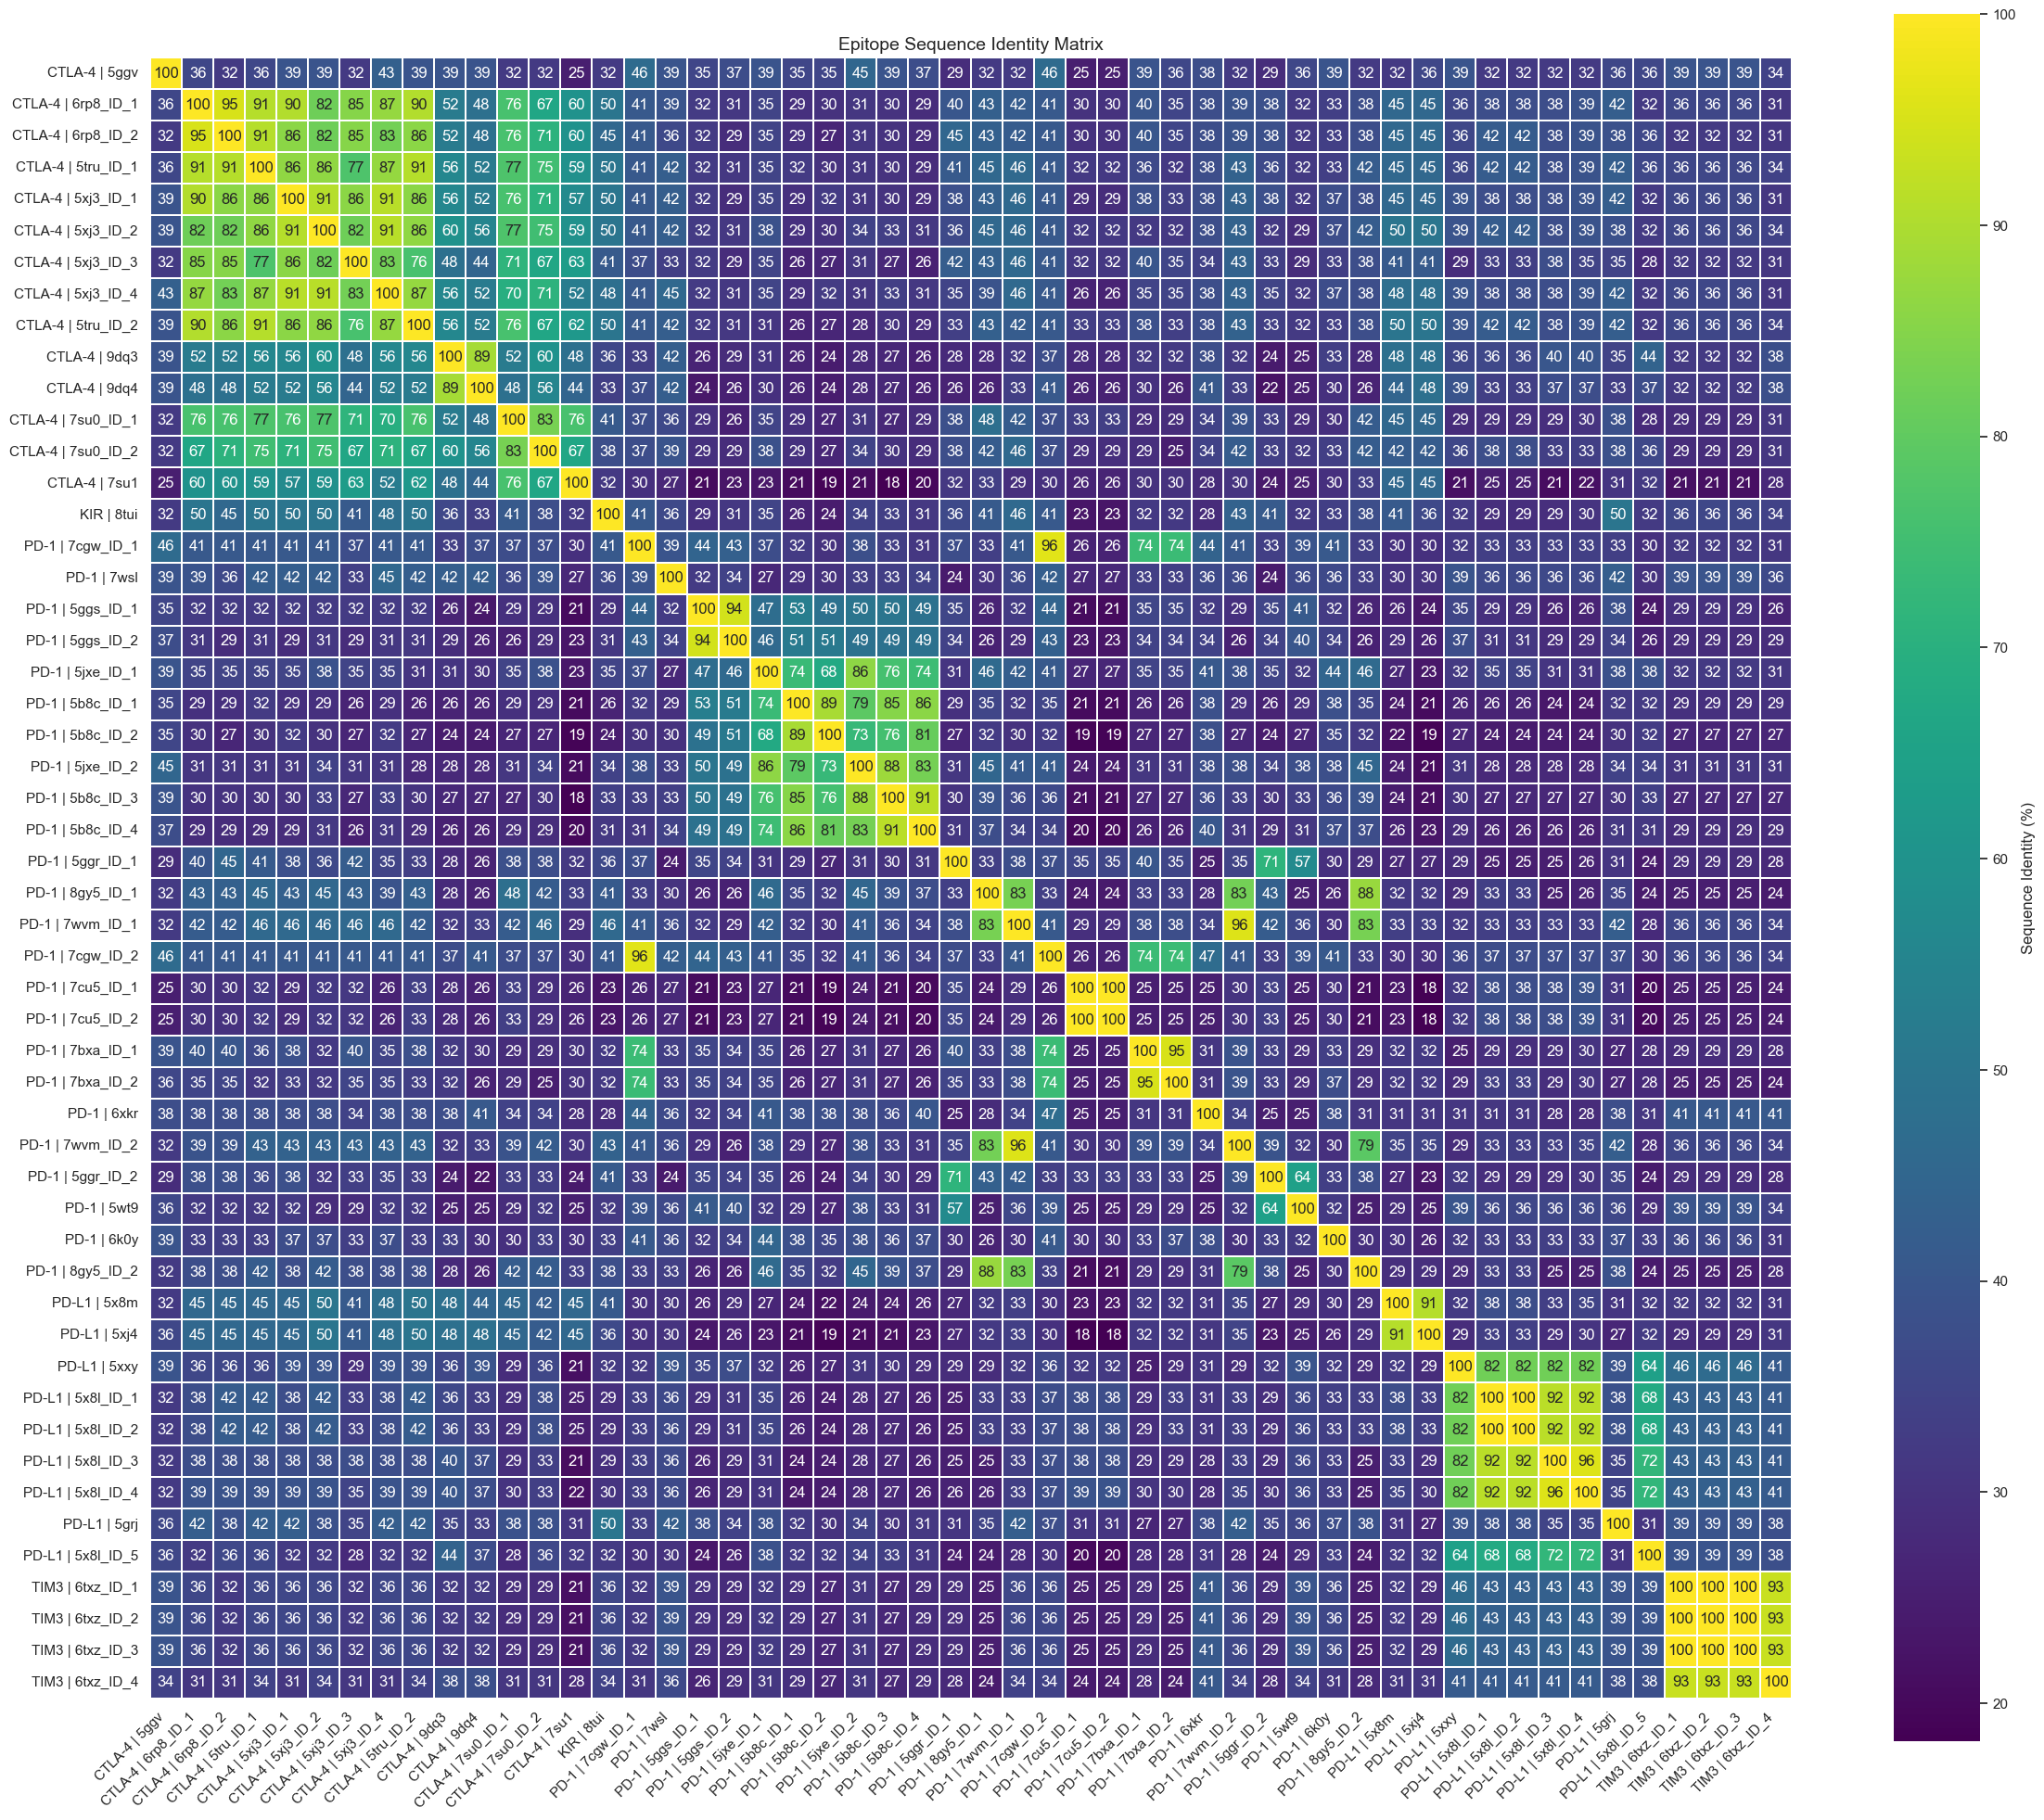

Cleaned-up heatmap saved as 'paratope_identity_heatmap_final.png'


In [160]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from collections import defaultdict, Counter

checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), # mit variable funktioniert unique nicht
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Create mapping from PDB ID → Checkpoint
pdb_to_checkpoint = {}
for checkpoint, pdb_list in pdb_ids.items():
    for pdb in pdb_list:
        pdb_to_checkpoint[pdb.lower()] = checkpoint

# Update row and column labels using base PDB ID
def get_checkpoint_label(pdb_id):
    base_id = pdb_id.lower().split('_')[0]  # e.g. "5x8l_ID_1" → "5x8l"
    checkpoint = pdb_to_checkpoint[base_id]
    return f"{checkpoint} | {pdb_id}"

df_identity = df_identity.copy()
df_identity.index = [get_checkpoint_label(p) for p in df_identity.index]
df_identity.columns = [get_checkpoint_label(p) for p in df_identity.columns]



annot_data = df_identity.applymap(lambda x: f"{x:.0f}")
mask = None

plt.figure(figsize=(24, 20))
sns.set(style="white", font_scale=1.0)
# annot_data = df.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


ax = sns.heatmap(
    df_identity, 
    annot=annot_data, 
    fmt="", 
    cmap="viridis", 
    mask=mask,
    square=True, 
    linewidths=0.3, 
    cbar_kws={"label": "Sequence Identity (%)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Epitope Sequence Identity Matrix", fontsize=14)
plt.tight_layout()

plt.savefig("paratope_identity_heatmap_final.png", dpi=300)
plt.show()

print("Cleaned-up heatmap saved as 'paratope_identity_heatmap_final.png'")

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2478452501.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


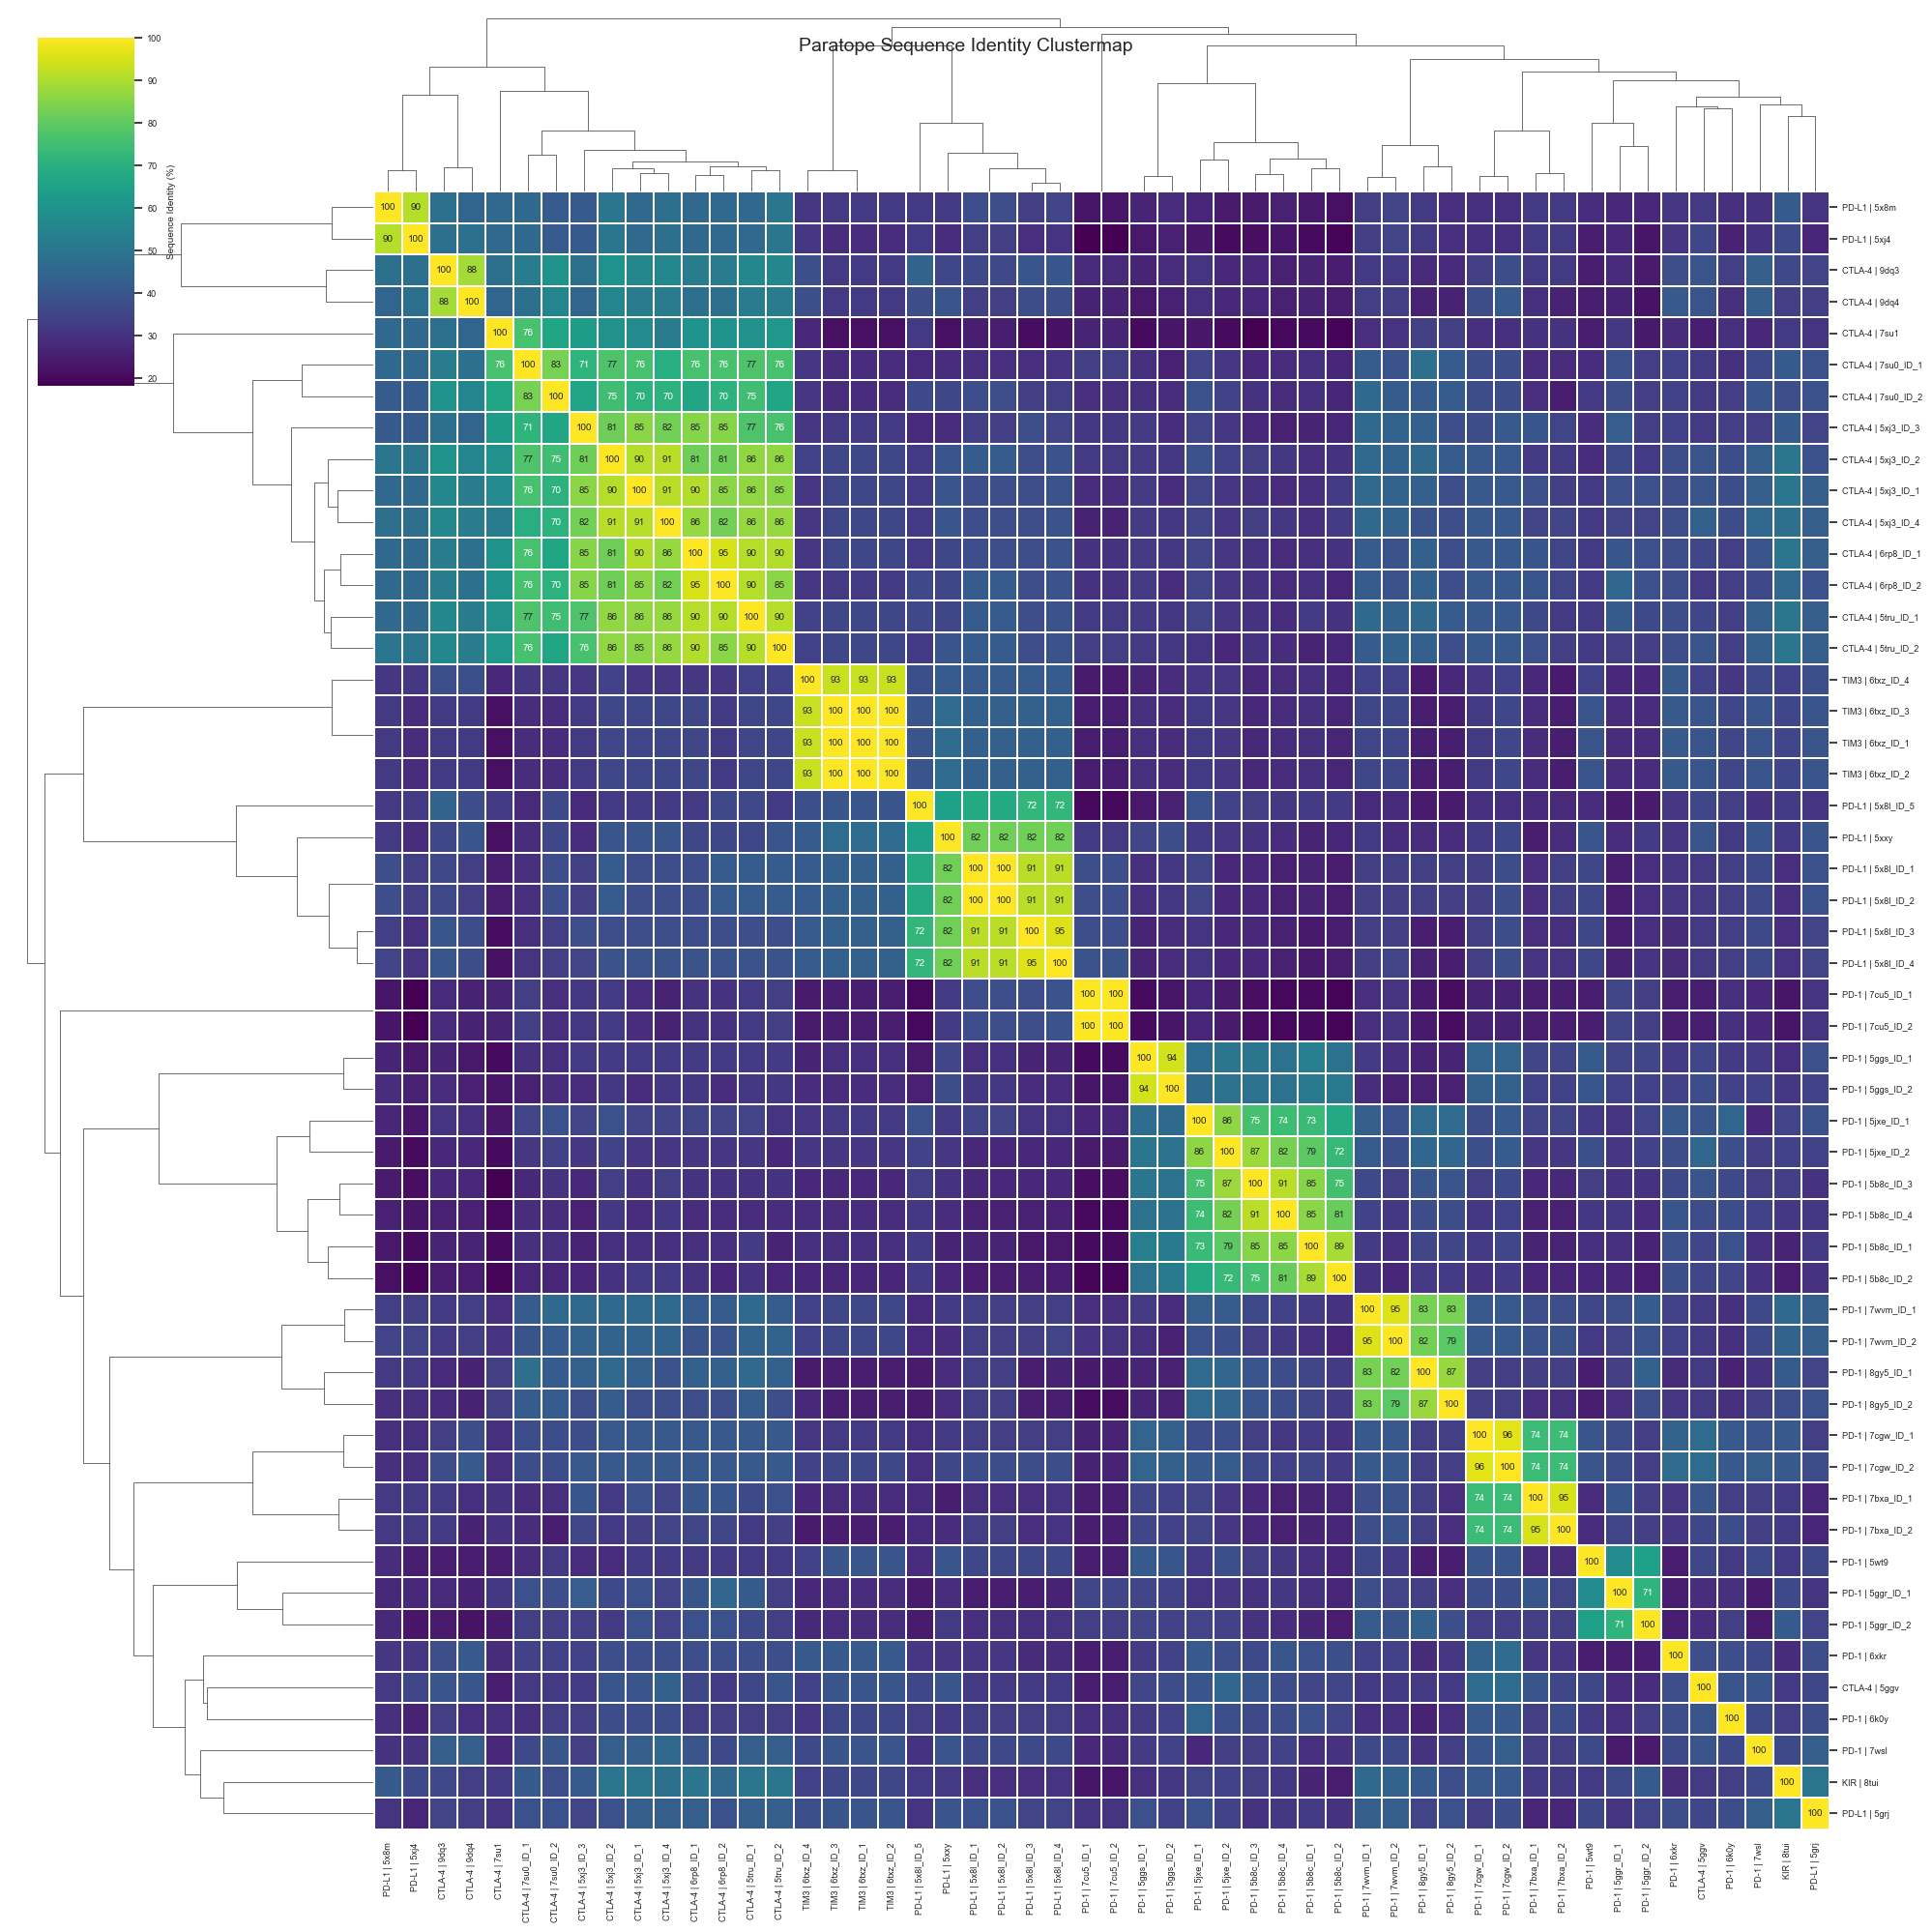

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: annotate only high identities
annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")

# Seaborn clustermap
sns.set(font_scale=0.6)  # smaller font for big matrices
g = sns.clustermap(
    df_identity,
    cmap="viridis",
    figsize=(20, 20),
    annot=annot_data,
    fmt="",
    linewidths=0.3,
    cbar_kws={"label": "Sequence Identity (%)"},
    dendrogram_ratio=(.2, .1),  # ratio for row/col dendrograms
    xticklabels=True,
    yticklabels=True
)



# Optional: save as high-res PDF
g.fig.suptitle("Paratope Sequence Identity Clustermap", fontsize=14)
plt.savefig("paratope_clustermap.pdf", dpi=300, bbox_inches="tight")
plt.show()


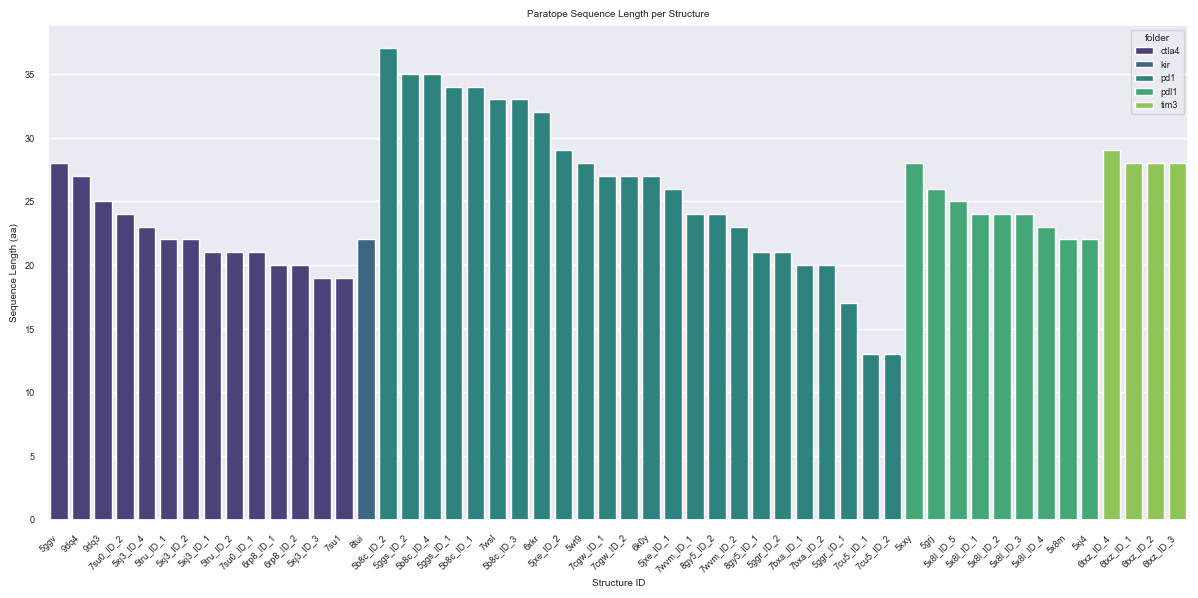

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add a column with the sequence length
df_seq["paratope_length"] = df_seq["paratope_sequence"].str.len()

# Sort for better visualization (optional)
df_seq_sorted = df_seq.sort_values(by=["folder", "paratope_length"], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_seq_sorted, x="structure_id", y="paratope_length", hue="folder", dodge=False, palette="viridis")

plt.title("Paratope Sequence Length per Structure")
plt.xlabel("Structure ID")
plt.ylabel("Sequence Length (aa)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("paratope_sequence_lengths.pdf", bbox_inches='tight')
plt.show()


In [111]:
df_norm.to_csv('binding_scores.csv', index=False)


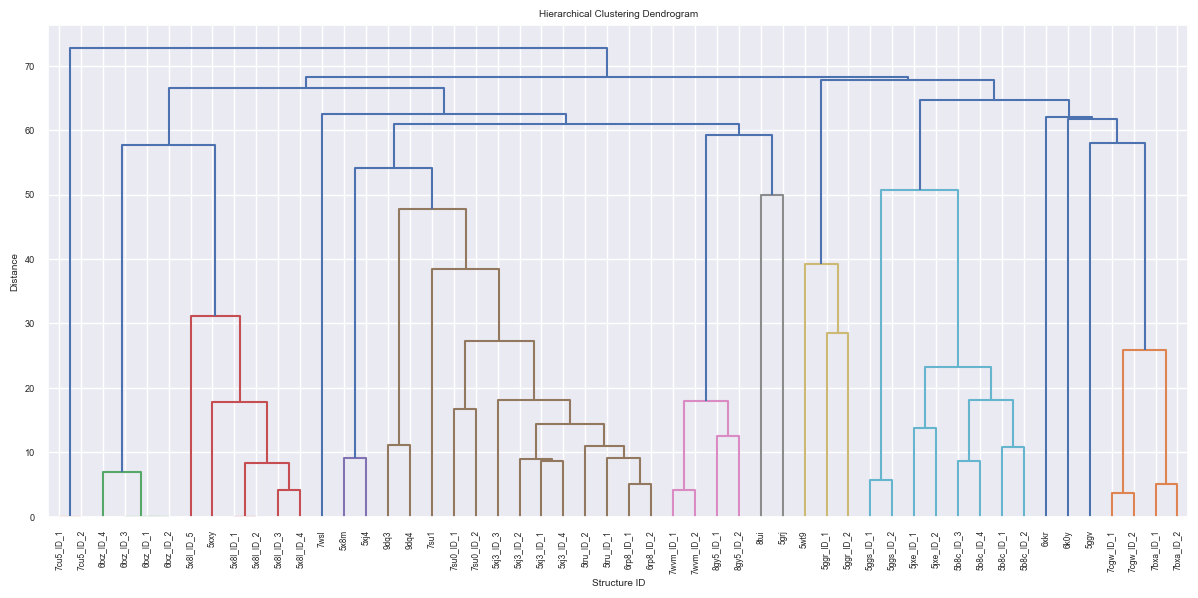

Cluster labels saved to 'cluster_labels.csv'


In [112]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load the distance matrix ===
# Replace with your actual distance matrix CSV
df_distance = pd.read_csv("paratope_sequence_comparison_matrix.csv", index_col=0)

# === Step 2: Convert similarity to distance if needed ===
# If your matrix contains similarity (e.g. % identity), convert it:
df_dist = 100 - df_distance  # assuming 100% is max similarity

# === Step 3: Condense the distance matrix ===
# Hierarchical clustering needs a condensed distance matrix (lower triangle)
condensed_dist = df_dist.values[np.triu_indices_from(df_dist, k=1)]

# === Step 4: Perform hierarchical clustering ===
Z = linkage(condensed_dist, method='average')  # or 'ward', 'single', etc.

# === Step 5: Assign clusters ===
# Adjust t or n_clusters as needed
n_clusters = 6
clusters = fcluster(Z, n_clusters, criterion='maxclust')

# === Step 6: Create a labeled DataFrame ===
df_labels = pd.DataFrame({
    'structure_id': df_dist.index,
    'cluster': clusters
})

# === Step 7: Plot dendrogram ===
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df_dist.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Structure ID")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# === Step 8: Save results ===
df_labels.to_csv("cluster_labels.csv", index=False)
print("Cluster labels saved to 'cluster_labels.csv'")


In [193]:
df.rename(columns={"cluster": "checkpoint"}, inplace=True)


# Do cluster have different binding affinities? 

In [218]:
# Neuer Versuch für Bindungsstärke zwischne den Clustern

manual_clusters = {
    "Cluster 1": ["5x8m", "5xj4", "9dq3", "9dq4", "7su1", "7su0", "5xj3", "6rp8", "5tru" ],
    "Cluster 2": ["6txz"],
    "Cluster 3": ["5xB1", "5xxy"],
    "Cluster 4": ["5ggs", "5jxe", "5b8c"],
    "Cluster 5": ["7wvm", "8gy5"],
    "Cluster 6": ["7cgw", "7bxa"],
    "Cluster 7": ["5wt9", "5ggr"]
}

# df -> Bindungsstärke

import pandas as pd

# 1. Manuelles Cluster-Dict in Liste umwandeln
cluster_rows = []
for cluster_name, pdb_list in manual_clusters.items():
    for pdb in pdb_list:
        cluster_rows.append({"pdb_id": pdb, "cluster": cluster_name})

# 2. DataFrame daraus
cluster_df = pd.DataFrame(cluster_rows)

# 3. Merge mit Haupt-DataFrame (z. B. mit binding_score)
merged_df = cluster_df.merge(df[["pdb_id", "binding_score", "checkpoint"]], on="pdb_id", how="left")

# Ergebnis anschauen
print(merged_df)



   pdb_id    cluster  binding_score checkpoint
0    5x8m  Cluster 1       0.363269      PD-L1
1    5xj4  Cluster 1       0.122888      PD-L1
2    9dq3  Cluster 1       0.397650     CTLA-4
3    9dq4  Cluster 1       0.946239     CTLA-4
4    7su1  Cluster 1       0.321967     CTLA-4
5    7su0  Cluster 1       0.213487     CTLA-4
6    7su0  Cluster 1       0.234503     CTLA-4
7    5xj3  Cluster 1       0.087400     CTLA-4
8    5xj3  Cluster 1       0.074734     CTLA-4
9    5xj3  Cluster 1       0.077047     CTLA-4
10   5xj3  Cluster 1       0.050417     CTLA-4
11   6rp8  Cluster 1       0.078650     CTLA-4
12   6rp8  Cluster 1       0.089596     CTLA-4
13   5tru  Cluster 1       0.088670     CTLA-4
14   5tru  Cluster 1       0.087214     CTLA-4
15   6txz  Cluster 2       0.166478       TIM3
16   6txz  Cluster 2       0.143712       TIM3
17   6txz  Cluster 2       0.147660       TIM3
18   6txz  Cluster 2       0.158448       TIM3
19   5xB1  Cluster 3            NaN        NaN
20   5xxy  Cl

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2830967183.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")


(0.0, 0.6)

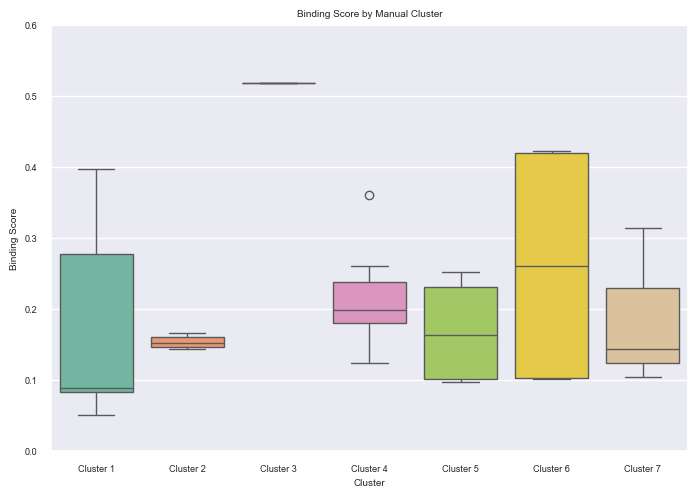

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")

plt.title("Binding Score by Manual Cluster")
plt.xlabel("Cluster")
plt.ylabel("Binding Score")
plt.tight_layout()
plt.ylim(0, 0.6)


In [209]:
from scipy.stats import kruskal

# 1. Daten nach Cluster gruppieren
grouped_scores = [
    group["binding_score"].dropna().values
    for name, group in merged_df.groupby("cluster")
]

# 2. Kruskal–Wallis-Test
stat, p = kruskal(*grouped_scores)

print(f"Kruskal–Wallis-Test: H = {stat:.3f}, p = {p:.4e}")


Kruskal–Wallis-Test: H = 5.459, p = 4.8641e-01



=== Cluster 1 ===
   pdb_id  binding_score checkpoint
0    5x8m       0.363269      PD-L1
1    5xj4       0.122888      PD-L1
2    9dq3       0.397650     CTLA-4
3    9dq4       0.946239     CTLA-4
4    7su1       0.321967     CTLA-4
5    7su0       0.213487     CTLA-4
6    7su0       0.234503     CTLA-4
7    5xj3       0.087400     CTLA-4
8    5xj3       0.074734     CTLA-4
9    5xj3       0.077047     CTLA-4
10   5xj3       0.050417     CTLA-4
11   6rp8       0.078650     CTLA-4
12   6rp8       0.089596     CTLA-4
13   5tru       0.088670     CTLA-4
14   5tru       0.087214     CTLA-4


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


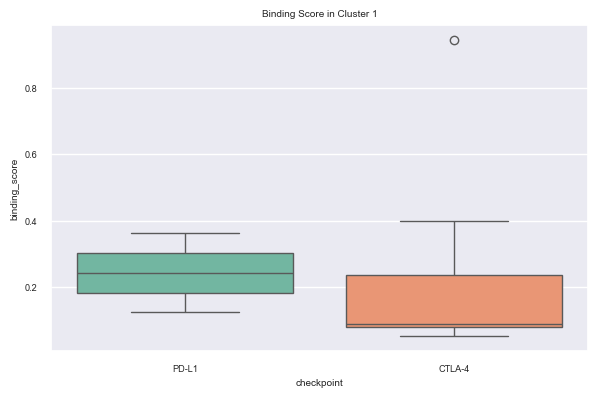


=== Cluster 2 ===
   pdb_id  binding_score checkpoint
15   6txz       0.166478       TIM3
16   6txz       0.143712       TIM3
17   6txz       0.147660       TIM3
18   6txz       0.158448       TIM3


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


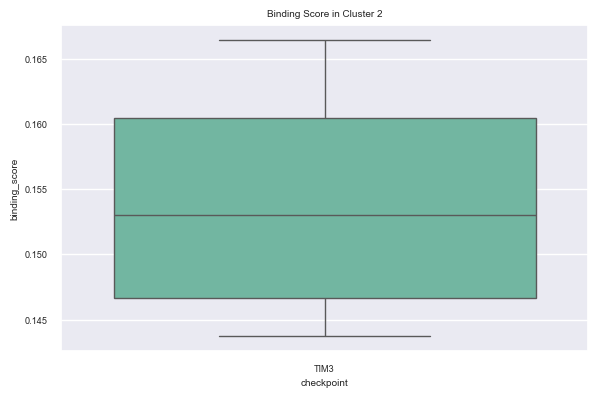


=== Cluster 3 ===
   pdb_id  binding_score checkpoint
19   5xB1            NaN        NaN
20   5xxy       0.518688      PD-L1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


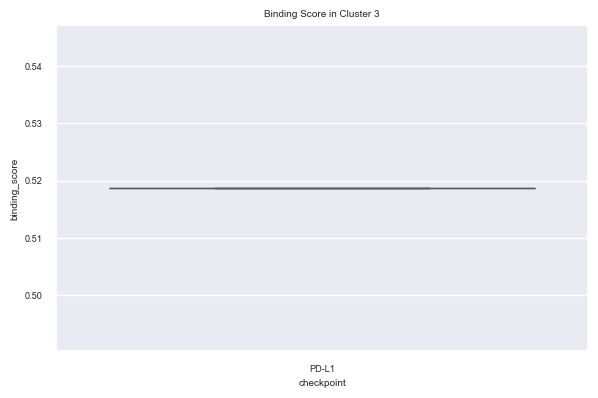


=== Cluster 4 ===
   pdb_id  binding_score checkpoint
21   5ggs       0.260194       PD-1
22   5ggs       0.360336       PD-1
23   5jxe       0.124032       PD-1
24   5jxe       0.126071       PD-1
25   5b8c       0.198566       PD-1
26   5b8c       0.229987       PD-1
27   5b8c       0.199163       PD-1
28   5b8c       0.198451       PD-1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


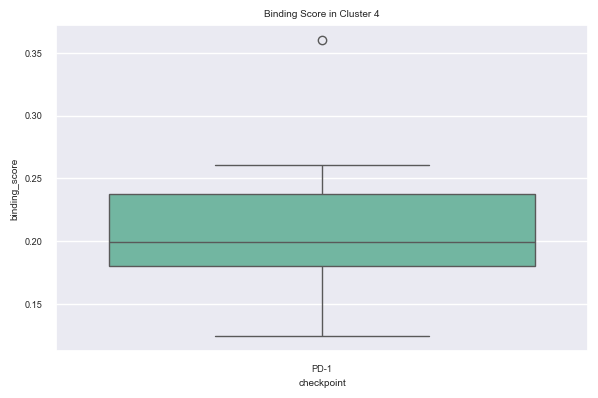


=== Cluster 5 ===
   pdb_id  binding_score checkpoint
29   7wvm       0.223532       PD-1
30   7wvm       0.097149       PD-1
31   8gy5       0.103942       PD-1
32   8gy5       0.252315       PD-1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


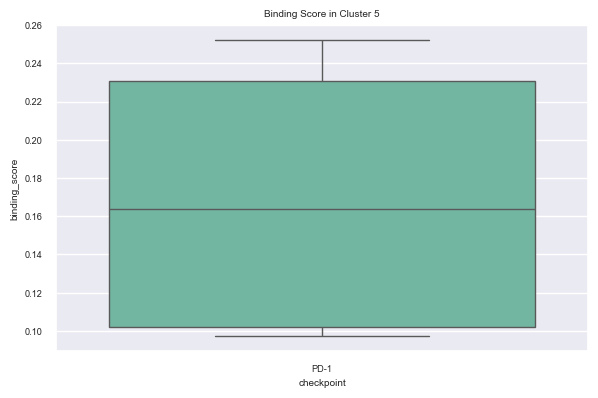


=== Cluster 6 ===
   pdb_id  binding_score checkpoint
33   7cgw       0.419402       PD-1
34   7cgw       0.421995       PD-1
35   7bxa       0.103305       PD-1
36   7bxa       0.101257       PD-1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


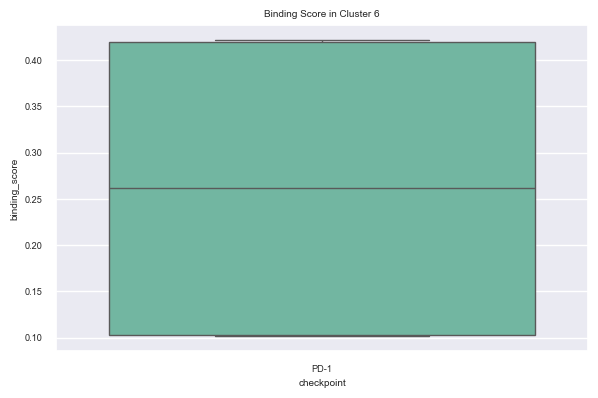


=== Cluster 7 ===
   pdb_id  binding_score checkpoint
37   5wt9       0.314146       PD-1
38   5ggr       0.144378       PD-1
39   5ggr       0.104701       PD-1


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2473602433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")


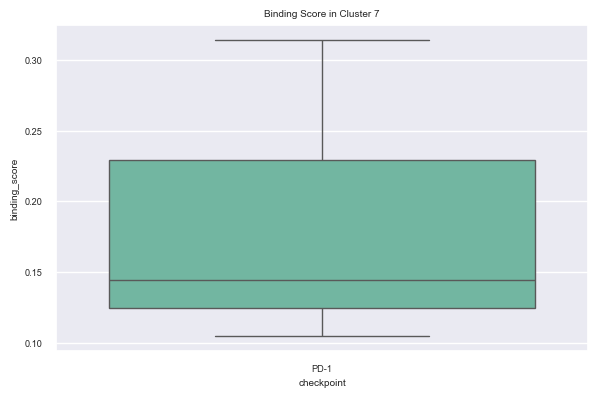

In [206]:
for cluster_name, group in merged_df.groupby("cluster"):
    print(f"\n=== {cluster_name} ===")
    print(group[["pdb_id", "binding_score", "checkpoint"]])
    
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=group, x="checkpoint", y="binding_score", palette="Set2")
    plt.title(f"Binding Score in {cluster_name}")
    plt.tight_layout()
    plt.show()



/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


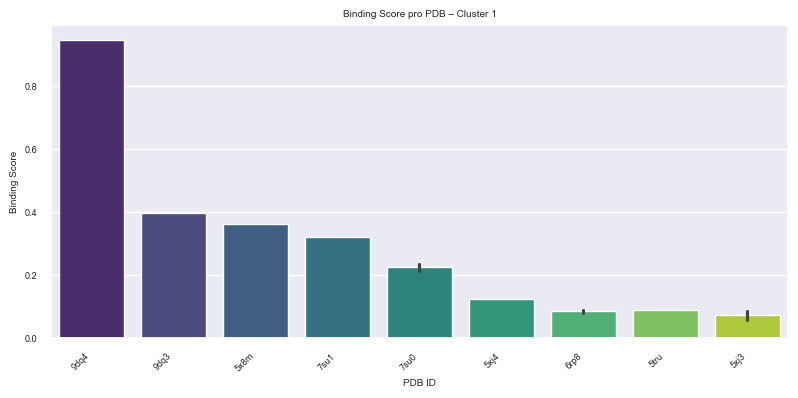

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


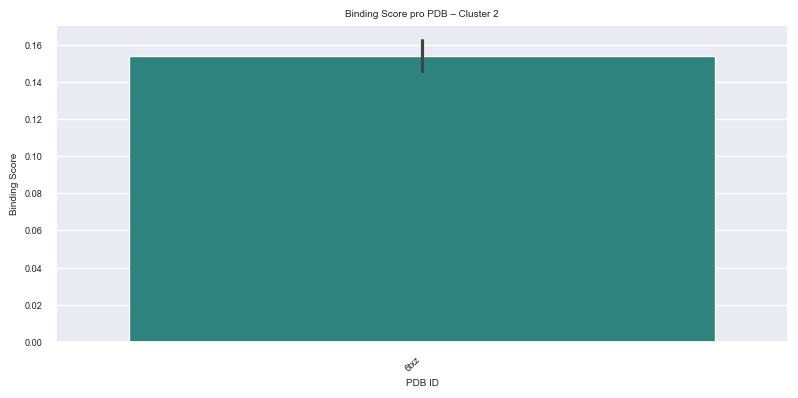

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


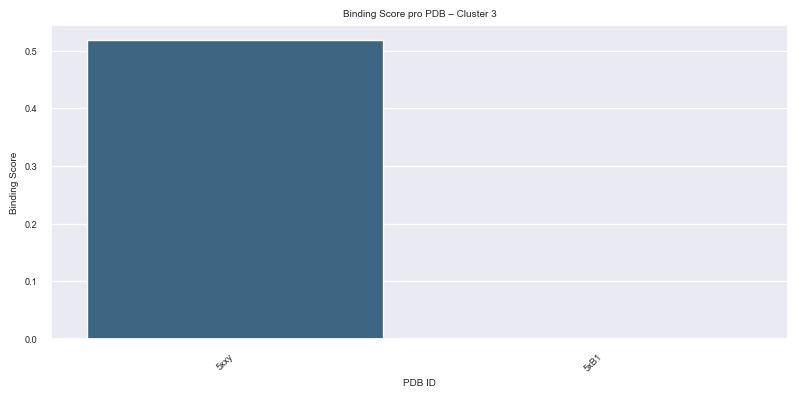

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


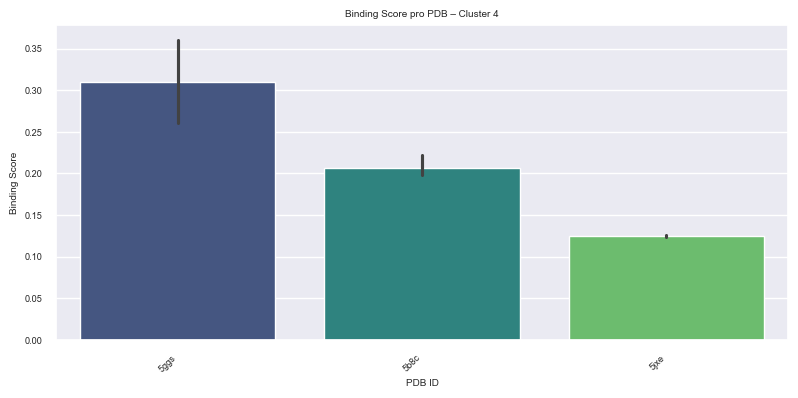

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


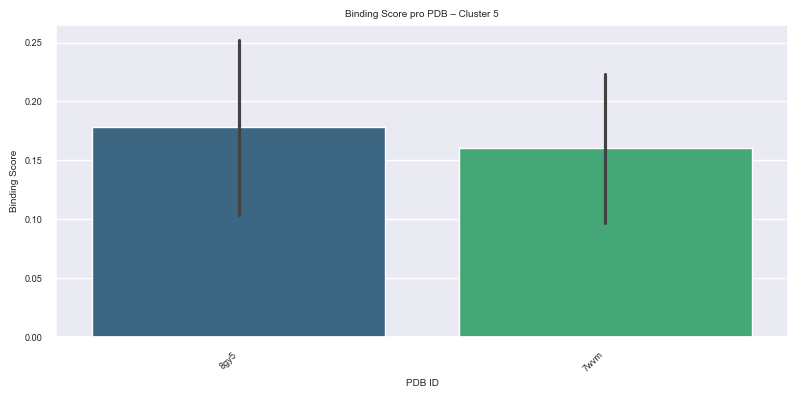

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


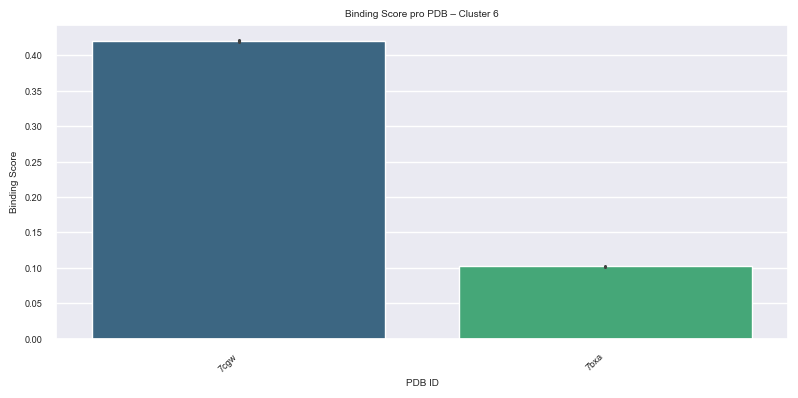

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_23499/2967408105.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


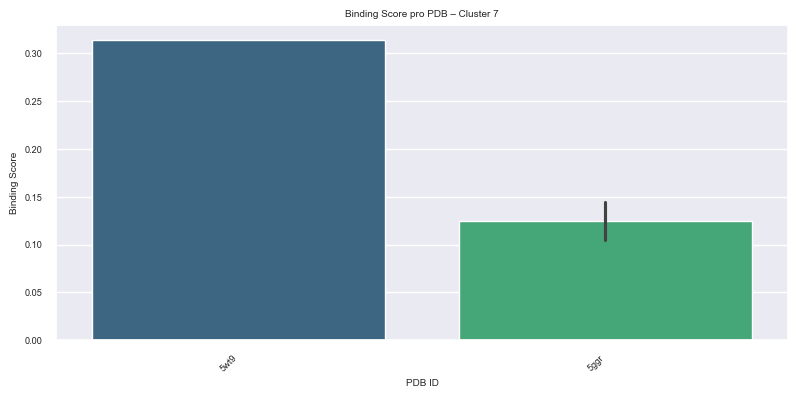

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clusterliste ermitteln
clusters = merged_df["cluster"].unique()

# Plot pro Cluster
for cluster_name in clusters:
    subset = merged_df[merged_df["cluster"] == cluster_name].sort_values("binding_score", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
    plt.title(f"Binding Score pro PDB – {cluster_name}")
    plt.xlabel("PDB ID")
    plt.ylabel("Binding Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
